In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google'

In [ ]:
%cd /content/gdrive/MyDrive/comp0197-cw2

/content/gdrive/MyDrive/comp0197-cw2


In [3]:
# autoreload modules if they are edited while using the notebook
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import model_UNet
from preprocessing_1_dataloader import get_data, un_normalise
from data_augmentation import augmentation, colorjiter, invert
import matplotlib.pyplot as plt

In [ ]:
#### Hyper-Param ####

# device to use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable GPU support
# device = 'cpu'
print(f'Using device: {device}')

# data parms
supervised_percent = 0.5    # what percent of training is to be labelled
img_resize = 64             # resize all images to this size 
is_mixed = False     # Training only on supervised data or not

# model params
depth = 3       # depth of unet
dropout_rate = 0.25

# Training params
batch_size = 16
epochs = 15
ramp_up = 5
consistency = 56
alpha = 0.8
global_step = 0
lr=1e-4

Using device: cuda:0


In [17]:
#### Initialisation ####
#create 2 network
modelS = model_UNet.UNet(in_channels=3, num_classes=2, depth=depth, dropout_rate=dropout_rate)
modelS = modelS.to(device)
modelT = model_UNet.UNet(in_channels=3, num_classes=2, depth=depth)
modelT = modelT.to(device)
modelT.eval()

UNet(
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_final): Conv2d(64, 2, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (up_convs): ModuleList(
    (0): UpConv(
      (upconv): ConvTranspose2d(256, 128, kernel_size=(2, 2), str

In [18]:

#create the losses
sup_crit = nn.CrossEntropyLoss().to(device)
unsup_crit = nn.CrossEntropyLoss().to(device)
#optimizer
optimizer = Adam(modelS.parameters(), lr=lr)

##data loader
mixed_train_loader, val_loader, test_loader = get_data(supervised_percent,1-supervised_percent,0.2,0.1, batch_size=batch_size, img_resize=img_resize, is_mixed_loader=is_mixed)

Using downloaded and verified file: ./data/images.tar.gz
Using downloaded and verified file: ./data/annotations.tar.gz
all images are =  7393


In [19]:
#Weigth coef for the Unsupervised
def wt(rampup_length, current, alpha):
    if rampup_length == 0:
                return 1.0
    else:
        current = np.clip(current, 0.0, rampup_length)
        phase = 1.0 - current / rampup_length
        return float(alpha * np.exp(-5.0 * phase * phase))


#update the Teacher weigth
def update_ema_variables(model, ema_model, alpha, global_step): 
    # Use the true average until the exponential average is more correct
    alpha = min(1 - 1 / (global_step + 1), alpha)
    for ema_param, param in zip(ema_model.parameters(), model.parameters()):
        ema_param.data.mul_(alpha).add_(1 - alpha, param.data)

In [20]:
def softmax_mse_loss(inputs, targets):

    assert inputs.requires_grad is True and targets.requires_grad is False
    assert inputs.size() == targets.size()  # (batch_size * num_classes * H * W)
    
    inputs = F.softmax(inputs, dim=1)
    targets = F.softmax(targets, dim=1)
    
    return F.mse_loss(inputs, targets, reduction='mean')  # take the mean over the batch_size

In [21]:
def evaluate_model(model, dataloader, device):
    
    intersection_total, union_total = 0, 0
    pixel_correct, pixel_count = 0, 0
    
    with torch.no_grad():
        for data in dataloader:
            imgs, labels = data
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            preds = torch.argmax(logits, dim=1)
            targets = torch.squeeze(labels)
            
            intersection_total += torch.logical_and(preds, targets).sum()
            union_total += torch.logical_or(preds, targets).sum()
            
            pixel_correct += (preds == targets).sum()
            pixel_count += targets.numel()
    iou = (intersection_total / union_total).item()
    accuracy = (pixel_correct / pixel_count).item()
    
    return accuracy, iou

In [115]:
def dice_loss(logits, tagets):
    preds_animal = F.softmax(logits, dim=1)
    tagets_animal = torch.squeeze(tagets)
    preds_animal = preds_animal[:,1,:,:]
    eps = 1e-6
    intersection = (preds_animal * tagets_animal).sum()
    dice_coef = (2. * intersection + eps) / ((preds_animal**2).sum() + (tagets_animal**2).sum() + eps)
    dice_loss = 1 - dice_coef
    return dice_loss

In [22]:
# check minibatch dimensions
data = next(iter(mixed_train_loader))
imgs, labels = data
imgs, labels = imgs.to(device), labels.to(device)

print(imgs.shape)

torch.Size([16, 3, 64, 64])


In [123]:
# Train
eval_freq = 1
for epoch in range(epochs):
        modelS.train()
        running_loss = 0

        for step, data in enumerate(mixed_train_loader):
                imgs, labs = data
                imgs = imgs.to(device)
                labs_nochannel = labs.squeeze().type(torch.LongTensor).to(device)
                labs = labs.to(device)

                optimizer.zero_grad()

                # Forward pass for student and teacher
                z = modelS(imgs) 
                # with torch.no_grad():
                #   z_bar = modelT(imgs)

                # Find img with label
                sup_idx = torch.tensor([(elem != -1).item() for elem in labs_nochannel[:, 0, 0]]).to(device) #If batchsize is the first dim

                assert len(sup_idx) != 0

                # Calculate losses
                Ls = dice_loss(z[sup_idx], labs[sup_idx])
                # Ls = sup_crit(z[sup_idx], labs[sup_idx])
                # Lu = softmax_mse_loss(z, z_bar).to(device)

                loss = Ls  # + wt(ramp_up, epoch, consistency) * Lu
                loss.backward()
                optimizer.step() 
                global_step += 1
                # update_ema_variables(modelS, modelT, alpha, global_step)
                running_loss += loss.item()

        if epoch == 0:
                print('\n{:<10s}{:<10s}'.format('', 'Running loss')) 
        
        print(f'Epoch: {epoch + 1:4d} - Loss: {running_loss:6.2f}')

        if (epoch % eval_freq == 0):
                modelS.eval()
                accuracy, iou = evaluate_model(modelS, val_loader, device)
                modelS.train()
                print(f'accuracy: {accuracy:2.0%}, iou: {iou:2.0%}')


          Running loss
Epoch:    1 - Loss:  28.09
accuracy: 91%, iou: 80%
Epoch:    2 - Loss:  26.57
accuracy: 91%, iou: 81%
Epoch:    3 - Loss:  25.55
accuracy: 91%, iou: 81%


KeyboardInterrupt: 

### View some of the predictions

In [124]:
data = next(iter(val_loader))
imgs, labels = data
imgs, labels = imgs.to(device), labels.to(device)
labels = torch.squeeze(labels)

preds = modelS(imgs)
_, preds_class = torch.max(preds, dim=1)

labels = labels.to('cpu')
imgs = imgs.to('cpu')
preds_class = preds_class.to('cpu')

/tmp/ipykernel_351/2299216677.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


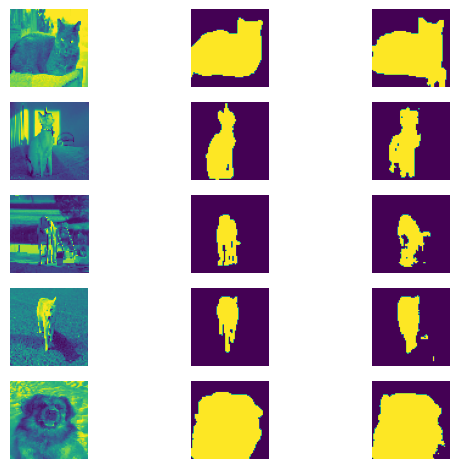

In [125]:
max_id = 5

fig, axs = plt.subplots(nrows=max_id, ncols=3)

for row in range(max_id):
  axs[row, 0].imshow(imgs[row,0])
  axs[row, 1].imshow(labels[row])
  axs[row, 2].imshow(preds_class[row])
  axs[row,0].axis('off')
  axs[row,1].axis('off')
  axs[row,2].axis('off')

fig.tight_layout()
fig.show()

In [128]:
modelS.to('cpu')
torch.save(modelS.state_dict(), 'models/unet_supervised_depth3_v1')

In [92]:
import model_UNet
import torch

modelS = model_UNet.UNet(num_classes=2, in_channels=3, depth=3)
modelS.load_state_dict(torch.load('models/unet_supervised_depth3_v1'))

/home/fred/repositories/comp0197-cw2/model_UNet.py:213: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
/home/fred/repositories/comp0197-cw2/model_UNet.py:214: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


<All keys matched successfully>